In [3]:
# ipython magic

# %reset -f
# %matplotlib notebook
# %load_ext autoreload
# %autoreload 2

In [1]:
import os
import time
import sys
sys.path.append('..')
sys.path.append(r'C:\Users\Robert Lees\Documents\Code\Vape\rob_suite2p')
# sys.path.append(r'C:\Users\Robert Lees\Documents\Code\suite2p')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import utils.interareal_analysis_class as iac
import pickle
import tifffile as tf
from scipy import spatial, stats

['C:\\ProgramData\\Anaconda3\\lib\\site-packages\\suite2p']


P:\rlees\Data\2019-08-14
['P:\\rlees\\Data\\2019-08-14\\J059\\2019-08-14_J059_t-002'] ['none'] ['none'] ['n']
Loading 429 traces labelled as cells
performing t-test on cells with mutliple comparisons correction


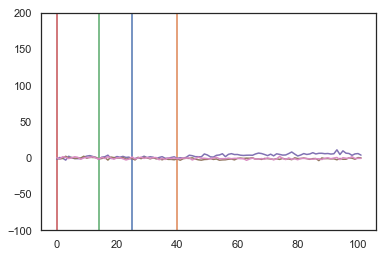

In [32]:
ss_id = '1PgSXs6BVHe9dACWEydykucN74rirNfOY4Vr_AmLcCdY'
sheet_name = '2019-08-14_J059'
pstation_path = r'P:\rlees\Data'
stim_channel = 'markpoints2packio'
pkl_folder = r'P:\rlees\pkl_files'
batch_size = 200
 
tiffs_pstation, naparms_pstation, paqs_pstation, stim_type = iac.experimentInfo(ss_id, sheet_name, pstation_path)
print(tiffs_pstation, naparms_pstation, paqs_pstation, stim_type)

paths = []

for tiff, naparm, paq in zip(tiffs_pstation, naparms_pstation, paqs_pstation):    
    addition = [tiff, naparm, paq]
    paths.append(addition)
    
# find the latest exp number for this dataset from the list of pkl files to increment for new pkl file name
pkl_file_list = os.listdir(pkl_folder)
exp_num_list = [pkl_file[-5] for pkl_file in pkl_file_list if sheet_name in pkl_file]
if len(exp_num_list) > 0:
    exp_number = int(max(exp_num_list))
    exp_number += 1
else:
    exp_number = 0

for i,_ in enumerate(paths):
    pkl_path = os.path.join(pkl_folder, sheet_name + '_exp{}.pkl'.format(exp_number))
    
    exp_obj = iac.interarealAnalysis(ss_id, sheet_name, paths[i], stim_type[i])
#     exp_obj.s2pRun(batch_size)
    exp_obj.s2pProcessing(subtract_neuropil=False)
    exp_obj.stimProcessing(stim_channel)
    
    # For sham stim of spontaneous data
#     exp_obj.stim_start_frames = stim_start_frames
#     exp_obj.duration_frames = duration_frames
#     exp_obj.n_trials = 100
    
    exp_obj.cellStaProcessing()

    with open(pkl_path, 'wb') as f:
        pickle.dump(exp_obj, f)
    
    exp_number += 1

In [1576]:
# pkl_path = r'P:\rlees\pkl_files\2019-08-15_RL055_exp1_random.pkl'

# with open(pkl_path, 'rb') as f:
#     exp_obj = pickle.load(f)

# stim_dur = exp_obj.stim_dur 

# pkl_path = r'P:\rlees\pkl_files\2019-08-15_RL055_exp0_spont_sham.pkl'

# with open(pkl_path, 'rb') as f:
#     exp_obj = pickle.load(f)

# exp_obj.stim_dur = stim_dur

# with open(pkl_path, 'wb') as f:
#     pickle.dump(exp_obj, f)

In [143]:
# Find photostim target positions in x,y pixel coords and find photostim resolution from averaging image around them
# Find photostim targeted cells and index, can then do analysis on non-targeted cells to find followers

for root, dirs, files in os.walk(pkl_folder):
    for file in files:
        pkl_path = os.path.join(pkl_folder, file)
        print('Pickle path:', pkl_path)
        
#         if any(s in pkl_path for s in ['random', 'sensory']):
        if 'spont_sham' in pkl_path:
           
            with open(pkl_path, 'rb') as f:
                exp_obj = pickle.load(f)

            exp_obj.n_targets = []
            exp_obj.target_coords = []
            exp_obj.target_areas = []
            exp_obj.targeted_cells = []
        

            # load naparm targets file for this experiment
            naparm_path = os.path.join(exp_obj.naparm_path, 'Targets')

            listdir = os.listdir(naparm_path)

            for path in listdir:
                if 'AllFOVTargets' in path:
                    target_file = path

            target_image = tf.imread(os.path.join(naparm_path, target_file))
            n = np.array([[0, 0],[0, 1]])
            target_image_scaled = np.kron(target_image, n)

            # use frame_x and frame_y to get bounding box of OBFOV inside the BAFOV, assume BAFOV always 1024x1024
            frame_x = exp_obj.frame_x
            frame_y = exp_obj.frame_y

            #bounding box coords
            x1 = 511 - frame_x/2
            x2 = 511 + frame_x/2
            y1 = 511 - frame_y/2
            y2 = 511 + frame_y/2

            #calc imaging galvo offset between BAFOV and t-series
            zoom = exp_obj.zoom
            scan_x = exp_obj.scan_x
            scan_y = exp_obj.scan_y

            ScanAmp_X = 2.62*2
            ScanAmp_Y = 2.84*2

            ScanAmp_V_FOV_X = ScanAmp_X / zoom
            ScanAmp_V_FOV_Y = ScanAmp_Y / zoom

            scan_pix_y = ScanAmp_V_FOV_Y / 1024
            scan_pix_x = ScanAmp_V_FOV_X / 1024

            offset_x = scan_x/scan_pix_x #offset between image centres in pixels
            offset_y = scan_y/scan_pix_y

            # add offset to the bounding box
            x1,x2,y1,y2 = round(x1+offset_x), round(x2+offset_x), round(y1-offset_y), round(y2-offset_y)

            # crop the target image using the offset bounding box to get the targets in t-series imaging space?
            target_image_scaled = target_image_scaled[y1:y2, x1:x2]
            tf.imwrite(os.path.join(naparm_path, 'target_image_scaled.tif'), target_image_scaled)
            
            targets = np.where(target_image_scaled>0)

            targetCoordinates = list(zip(targets[1], targets[0]))
            print('Number of targets:', len(targetCoordinates))
                    
            exp_obj.target_coords = targetCoordinates
            exp_obj.n_targets = len(targetCoordinates)

            target_areas = []

            radius = 10/exp_obj.pix_sz_x
            for coord in targetCoordinates:
                target_area = ([item for item in points_in_circle_np(radius, x0=coord[0], y0=coord[1])])
                target_areas.append(target_area)

            exp_obj.target_areas = target_areas

            print('Searching for targeted cells...')

            for cell in range(exp_obj.n_units[0]):
                flag = 0
                
                for x, y in zip(exp_obj.cell_x[0][cell], exp_obj.cell_y[0][cell]):
                    for target in range(exp_obj.n_targets):
                        for a, b in exp_obj.target_areas[target]:
                            if x == a and y == b:
                                flag = 1

                if flag==1:
                    exp_obj.targeted_cells.append(1)
                else:
                    exp_obj.targeted_cells.append(0)

            print('Search completed.\n')
                    
            with open(pkl_path, 'wb') as f:
                pickle.dump(exp_obj, f)

Pickle path: P:\rlees\pkl_files\2019-06-11_J048_exp0_random.pkl
Pickle path: P:\rlees\pkl_files\2019-06-11_J048_exp1_sensory.pkl
Pickle path: P:\rlees\pkl_files\2019-06-13_J052_exp0_random.pkl
Pickle path: P:\rlees\pkl_files\2019-06-13_J052_exp1_sensory.pkl
Pickle path: P:\rlees\pkl_files\2019-06-25_RL048_exp0_random.pkl
Pickle path: P:\rlees\pkl_files\2019-06-25_RL048_exp1_sensory.pkl
Pickle path: P:\rlees\pkl_files\2019-07-15_RL052_exp0_random.pkl
Pickle path: P:\rlees\pkl_files\2019-07-15_RL052_exp1_sensory.pkl
Pickle path: P:\rlees\pkl_files\2019-08-14_J058_exp0_random.pkl
Pickle path: P:\rlees\pkl_files\2019-08-14_J058_exp1_sensory.pkl
Pickle path: P:\rlees\pkl_files\2019-08-14_J059_exp0_spont.pkl
Pickle path: P:\rlees\pkl_files\2019-08-14_J059_exp0_spont_sham.pkl
Number of targets: 29
Searching for targeted cells...
Search completed.

Pickle path: P:\rlees\pkl_files\2019-08-14_J059_exp1_random.pkl
Pickle path: P:\rlees\pkl_files\2019-08-14_J059_exp2_sensory.pkl
Pickle path: P:\rl

In [101]:
#get target masks and mean images saved in respective suite2p folders

pkl_folder = r'P:\rlees\pkl_files'

for root, dirs, files in os.walk(pkl_folder):
    for file in files:
        pkl_path = os.path.join(pkl_folder, file)
        
        if any(s in pkl_path for s in ['random', 'sensory']):
            
            with open(pkl_path, 'rb') as f:
                exp_obj = pickle.load(f)
            
            s2p_path = os.path.join(exp_obj.tiff_path, 'suite2p', 'plane0')

            os.chdir(s2p_path)

            stat = np.load('stat.npy')
            ops = np.load('ops.npy').item()
            iscell = np.load('iscell.npy')           
            
            im = np.zeros((ops['Ly'], ops['Lx']), dtype='uint16')

            for n in range(0,len(iscell)):
                if iscell[n][0] == 1:
                    ypix = stat[n]['ypix']
                    xpix = stat[n]['xpix']
                    im[ypix,xpix] = 255

            tf.imwrite('cell_masks.tif', im)
            
            im = np.zeros((ops['Ly'], ops['Lx']), dtype='uint16')
            
            target_ids = [exp_obj.cell_id[0][i] for i,b in enumerate(exp_obj.targeted_cells) if b==1]
            
            for n in range(0,len(iscell)):
                if n in target_ids:
                    ypix = stat[n]['ypix']
                    xpix = stat[n]['xpix']
                    im[ypix,xpix] = 255

            tf.imwrite('target_cell_masks.tif', im)

            mean_img = ops['meanImg']

            mean_img = np.array(mean_img, dtype='uint16')
            tf.imwrite('mean_image.tif', mean_img)

In [141]:
#get some basic summary stats from the dataset

pkl_folder = r'P:\rlees\pkl_files'

n_units = []
n_targets = []
n_targeted_cells = []
stim_dur = []
stim_freq = []

for root, dirs, files in os.walk(pkl_folder):
    for file in files:
        pkl_path = os.path.join(pkl_folder, file)
        
        if any(s in pkl_path for s in ['random', 'sensory']):
            with open(pkl_path, 'rb') as f:
                exp_obj = pickle.load(f)

            print(exp_obj.tiff_path)

            print(exp_obj.n_units, exp_obj.n_targets)
            n_units.append(exp_obj.n_units[0])
            n_targets.append(exp_obj.n_targets)
            n_targeted_cells.append(len([i for i in exp_obj.targeted_cells if i==1]))
            stim_dur.append(exp_obj.stim_dur)
            stim_freq.append( ( 1 / ( ( (exp_obj.single_stim_dur*exp_obj.n_shots) * exp_obj.n_groups-1 ) + ( exp_obj.inter_point_delay * exp_obj.n_groups ) ) ) *1000 )

P:\rlees\Data\2019-06-11\J048\2019-06-11_J048_t-005
[614] 50
P:\rlees\Data\2019-06-11\J048\2019-06-11_J048_t-006
[718] 23
P:\rlees\Data\2019-06-13\J052\2019-06-13_J052_t-004
[519, 413] 123
P:\rlees\Data\2019-06-13\J052\2019-06-13_J052_t-005
[601, 703] 40
P:\sarmstrong\Data\2019-06-25\RL048\2019-06-24_RL048_t-005
[600] 100
P:\sarmstrong\Data\2019-06-25\RL048\2019-06-24_RL048_t-006\MPTIFF
[769] 34
P:\rlees\Data\2019-07-15\2019-07-15_RL052\2019-07-15_RL052_t-007
[661] 89
P:\rlees\Data\2019-07-15\2019-07-15_RL052\2019-07-15_RL052_t-008
[922] 38
P:\rlees\Data\2019-08-14\J058\2019-08-14_J058_t-007
[441] 18
P:\rlees\Data\2019-08-14\J058\2019-08-14_J058_t-008
[411] 26
P:\rlees\Data\2019-08-14\J059\2019-08-14_J059_t-006
[462] 29
P:\rlees\Data\2019-08-14\J059\2019-08-14_J059_t-005
[506] 21
P:\rlees\Data\2019-08-15\RL055\2019-08-15_RL055_t-006
[502] 20
P:\rlees\Data\2019-08-15\RL055\2019-08-15_RL055_t-005
[480] 18


    n_units  n_targets  n_targeted_cells  stim_dur  stim_freq target_groups
0       614         50                55     445.0  34.482759        random
1       718         23                36     445.0  34.482759       sensory
2       519        123                87     595.0  13.513514        random
3       601         40                41     235.0  34.482759       sensory
4       600        100                80     595.0  16.949153        random
5       769         34                38     295.0  34.482759       sensory
6       661         89               100     595.0  16.949153        random
7       922         38                53     295.0  34.482759       sensory
8       441         18                21     295.0  34.482759        random
9       411         26                31     310.0  22.727273       sensory
10      462         29                24     295.0  34.482759        random
11      506         21                28     295.0  34.482759       sensory
12      502 

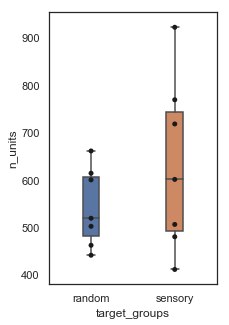

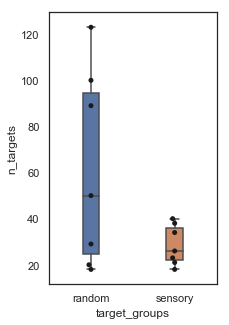

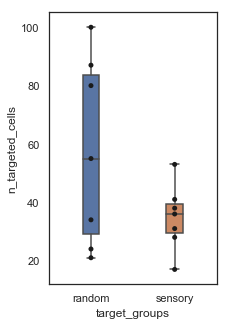

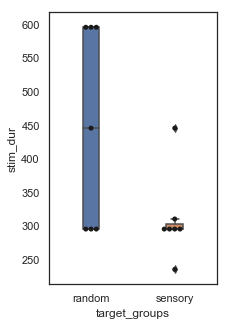

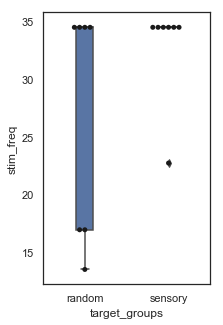

In [142]:
#store and plot basic stats of dataset

df = pd.DataFrame(data=list(zip(n_units, n_targets, n_targeted_cells, stim_dur, stim_freq)), columns=['n_units', 'n_targets', 'n_targeted_cells', 'stim_dur', 'stim_freq'])
df['target_groups'] = np.resize(['random','sensory'], (14))
print(df)

for column in df.columns[:-1]:
    plt.figure(figsize=(3,5))
    sns.boxplot(x='target_groups', y=column, data=df, width=0.2)
    sns.swarmplot(x='target_groups', y=column, data=df, color='k', size=5)

P:\rlees\pkl_files\2019-06-11_J048_exp0_random.pkl
P:\rlees\pkl_files\2019-06-11_J048_exp1_sensory.pkl
P:\rlees\pkl_files\2019-06-13_J052_exp0_random.pkl
P:\rlees\pkl_files\2019-06-13_J052_exp1_sensory.pkl
P:\rlees\pkl_files\2019-06-25_RL048_exp0_random.pkl
P:\rlees\pkl_files\2019-06-25_RL048_exp1_sensory.pkl
P:\rlees\pkl_files\2019-07-15_RL052_exp0_random.pkl
P:\rlees\pkl_files\2019-07-15_RL052_exp1_sensory.pkl
P:\rlees\pkl_files\2019-08-14_J058_exp0_random.pkl
P:\rlees\pkl_files\2019-08-14_J058_exp1_sensory.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp0_spont.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp0_spont_sham.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp1_random.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp2_sensory.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp0_spont.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp0_spont_sham.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp1_random.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp2_sensory.pkl


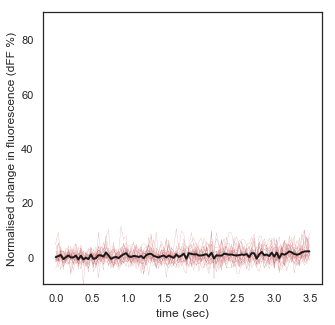

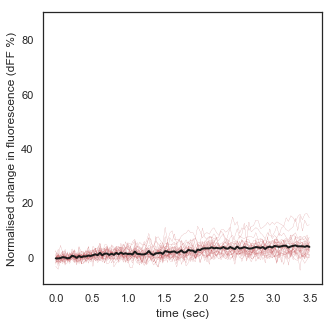

In [150]:
#make target STA traces

mean_sta_amp = []

for root, dirs, files in os.walk(pkl_folder):
    for file in files:
        pkl_path = os.path.join(pkl_folder, file)
        print(pkl_path)
        
        if any(s in pkl_path for s in ['random', 'sensory']):
#         if 'spont_sham' in pkl_path:
            
            with open(pkl_path, 'rb') as f:
                exp_obj = pickle.load(f)
            
            sta_amp = []
            targeted_sta = []

            for cell,_ in enumerate(exp_obj.targeted_cells):
                if exp_obj.targeted_cells[cell]==1:
                    targeted_sta.append(exp_obj.stas[0][cell])
                    sta_amp.append(exp_obj.sta_amplitudes[0][cell])
                               
            mean_sta = np.nanmean(targeted_sta,axis=0)
            mean_sta_amp.append(np.nanmean(sta_amp,axis=0))
            
            plt.figure(figsize=(5,5));

            for sta,_ in enumerate(targeted_sta):
                a = range(0,len(targeted_sta[sta]))
                b = [x/exp_obj.fps for x in a]
                plt.plot(b, targeted_sta[sta], 'r--', lw=0.2);
                plt.ylim((-10,90))
            plt.plot(b, mean_sta, 'k', lw=2);
            plt.xlabel('time (sec)')
            plt.ylabel('Normalised change in fluorescence (dFF %)')

    n_units  n_targets  n_targeted_cells  stim_dur  stim_freq target_groups  \
0       614         50                55     445.0  34.482759        random   
1       718         23                36     445.0  34.482759       sensory   
2       519        123                87     595.0  13.513514        random   
3       601         40                41     235.0  34.482759       sensory   
4       600        100                80     595.0  16.949153        random   
5       769         34                38     295.0  34.482759       sensory   
6       661         89               100     595.0  16.949153        random   
7       922         38                53     295.0  34.482759       sensory   
8       441         18                21     295.0  34.482759        random   
9       411         26                31     310.0  22.727273       sensory   
10      462         29                24     295.0  34.482759        random   
11      506         21                28     295.0  

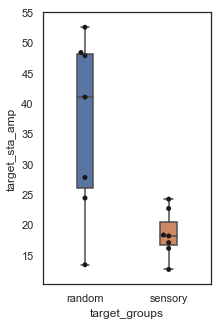

In [149]:
df['target_sta_amp'] = mean_sta_amp
print(df)

plt.figure(figsize=(3,5))
sns.boxplot(x='target_groups', y='target_sta_amp', data=df, width=0.2)
sns.swarmplot(x='target_groups', y='target_sta_amp', data=df, color='k', size=5)

P:\rlees\pkl_files\2019-06-11_J048_exp0_random.pkl
P:\rlees\pkl_files\2019-06-11_J048_exp1_sensory.pkl
P:\rlees\pkl_files\2019-06-13_J052_exp0_random.pkl
P:\rlees\pkl_files\2019-06-13_J052_exp1_sensory.pkl
P:\rlees\pkl_files\2019-06-25_RL048_exp0_random.pkl
P:\rlees\pkl_files\2019-06-25_RL048_exp1_sensory.pkl
P:\rlees\pkl_files\2019-07-15_RL052_exp0_random.pkl
P:\rlees\pkl_files\2019-07-15_RL052_exp1_sensory.pkl
P:\rlees\pkl_files\2019-08-14_J058_exp0_random.pkl
P:\rlees\pkl_files\2019-08-14_J058_exp1_sensory.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp0_spont.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp0_spont_sham.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp1_random.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp2_sensory.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp0_spont.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp0_spont_sham.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp1_random.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp2_sensory.pkl


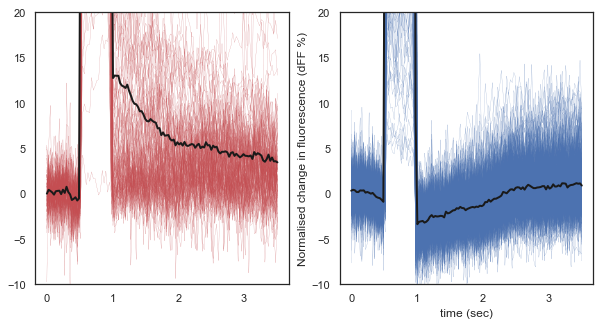

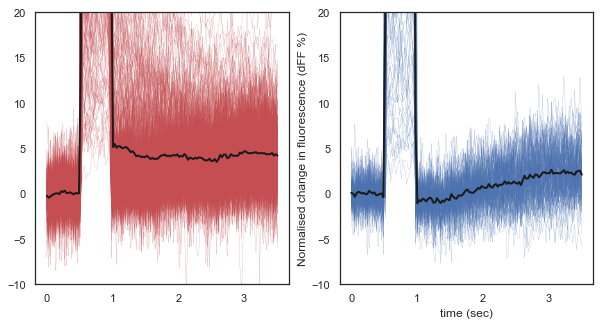

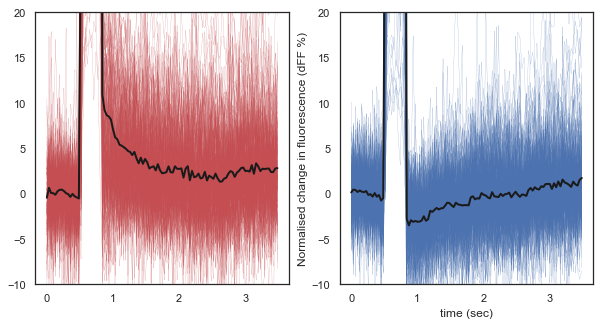

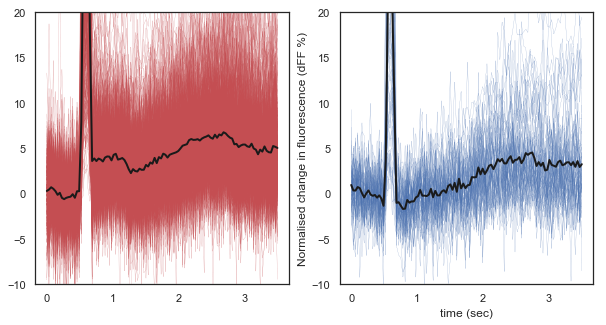

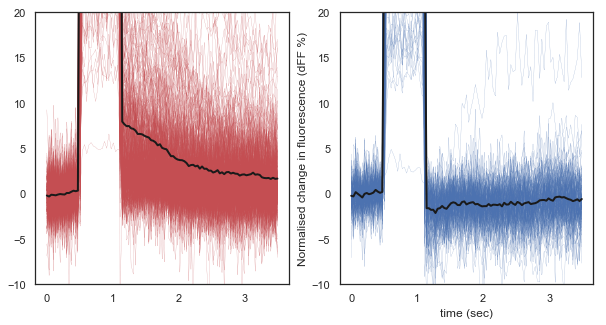

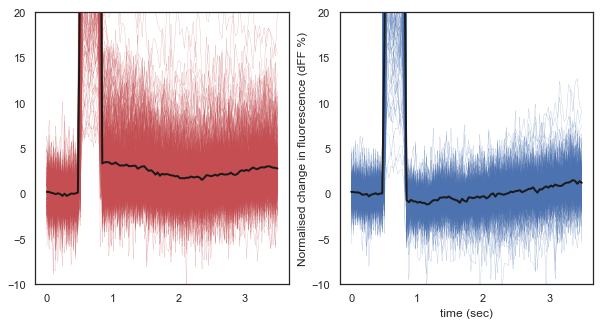

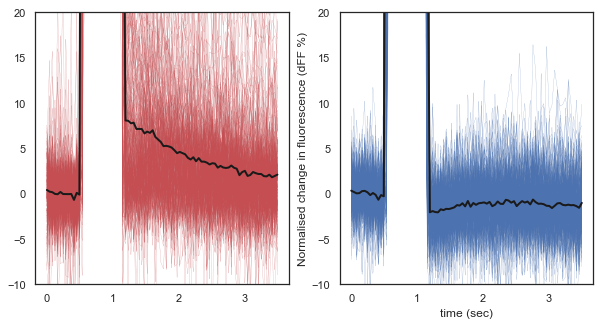

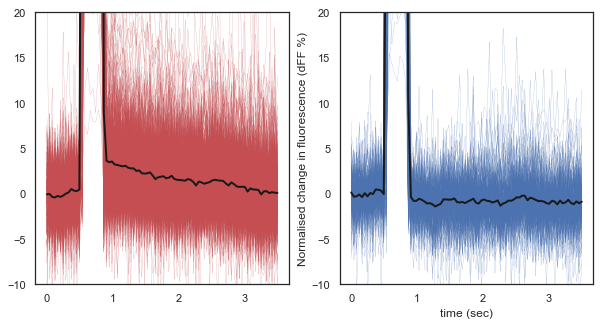

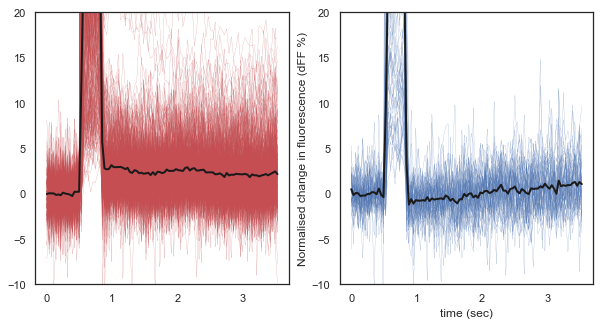

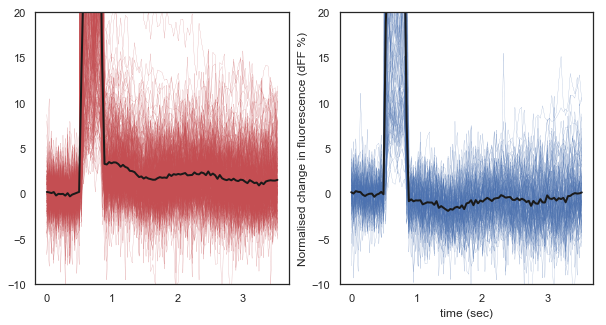

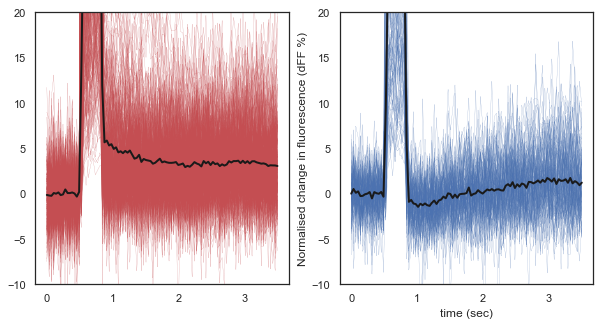

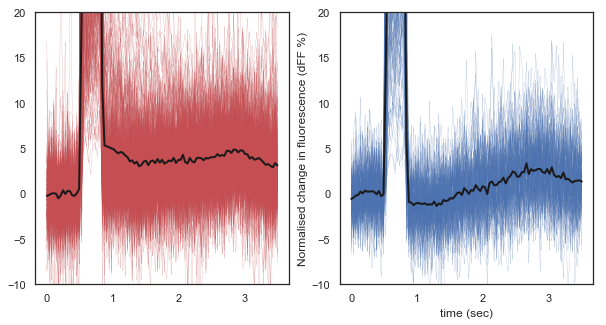

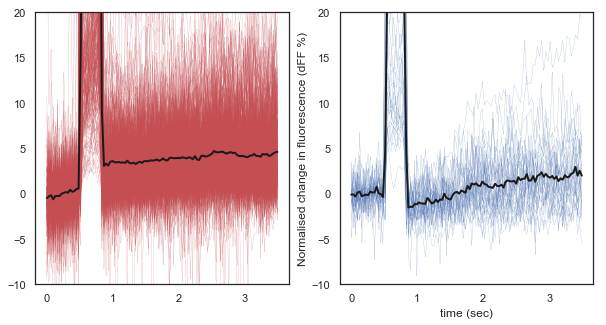

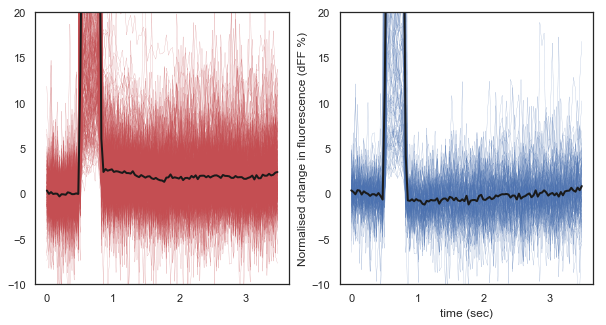

In [189]:
#make follower STA traces

mean_sta_amp_neg = []
mean_sta_amp_pos = []

for root, dirs, files in os.walk(pkl_folder):
    for file in files:
        pkl_path = os.path.join(pkl_folder, file)
        print(pkl_path)
        
        if any(s in pkl_path for s in ['random', 'sensory']):
#         if 'spont_sham' in pkl_path:
            
            with open(pkl_path, 'rb') as f:
                exp_obj = pickle.load(f)
            
            follower_sta_positive = []
            sta_amp_pos = []
            follower_sta_negative = []
            sta_amp_neg = []
            
            for cell,_ in enumerate(exp_obj.targeted_cells):
                if exp_obj.targeted_cells[cell]==0 and exp_obj.sta_amplitudes[0][cell] > 0:
                    follower_sta_positive.append(exp_obj.stas[0][cell])
                    sta_amp_pos.append(exp_obj.sta_amplitudes[0][cell])
            
                if exp_obj.targeted_cells[cell]==0 and exp_obj.sta_amplitudes[0][cell] < 0:
                    follower_sta_negative.append(exp_obj.stas[0][cell])
                    sta_amp_neg.append(exp_obj.sta_amplitudes[0][cell])
                    
            if np.shape(follower_sta_positive)[0] > 0:
                mean_sta = np.mean(follower_sta_positive,axis=0)
                mean_sta_amp_pos.append(np.nanmean(sta_amp_pos))
                 
                plt.figure(figsize=(10,5));
                ax1 = plt.subplot(121)
                ax2 = plt.subplot(122)

                for sta,_ in enumerate(follower_sta_positive):
                    a = range(0,len(follower_sta_positive[sta]))
                    b = [x/exp_obj.fps for x in a]
                    ax1.plot(b, follower_sta_positive[sta], 'r--', lw=0.2);
                    ax1.set_ylim((-10, 20))
                ax1.plot(b, mean_sta, 'k', lw=2);
                plt.xlabel('time (sec)')
                plt.ylabel('Normalised change in fluorescence (dFF %)')
            
            if np.shape(follower_sta_negative)[0] > 0:
                mean_sta = np.mean(follower_sta_negative,axis=0)
                mean_sta_amp_neg.append(np.nanmean(sta_amp_neg))

                for sta,_ in enumerate(follower_sta_negative):
                    a = range(0,len(follower_sta_negative[sta]))
                    b = [x/exp_obj.fps for x in a]
                    ax2.plot(b, follower_sta_negative[sta], 'b--', lw=0.2);
                    ax2.set_ylim((-10, 20))
                ax2.plot(b, mean_sta, 'k', lw=2);
                plt.xlabel('time (sec)')
                plt.ylabel('Normalised change in fluorescence (dFF %)')

(0, 12)

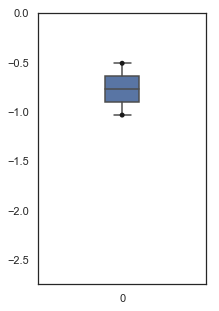

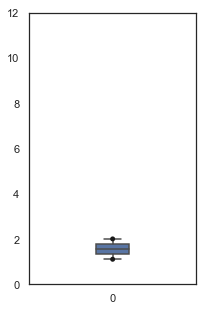

In [176]:
# plot sham 'follower' response amplitudes

plt.figure(figsize=(3,5))
sns.boxplot(data=mean_sta_amp_neg, width=0.2)
sns.swarmplot(data=mean_sta_amp_neg, color='k', size=5)
plt.ylim(-2.75, 0)

plt.figure(figsize=(3,5))
sns.boxplot(data=mean_sta_amp_pos, width=0.2)
sns.swarmplot(data=mean_sta_amp_pos, color='k', size=5)
plt.ylim(0, 12)

(-2.75, 0)

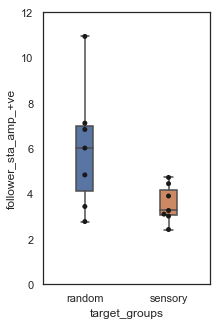

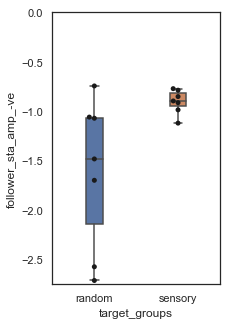

In [171]:
df['follower_sta_amp_+ve'] = mean_sta_amp_pos
df['follower_sta_amp_-ve'] = mean_sta_amp_neg
print(df)

plt.figure(figsize=(3,5))
sns.boxplot(x='target_groups', y='follower_sta_amp_+ve', data=df, width=0.2)
sns.swarmplot(x='target_groups', y='follower_sta_amp_+ve', data=df, color='k', size=5)
plt.ylim(0, 12)

plt.figure(figsize=(3,5))
sns.boxplot(x='target_groups', y='follower_sta_amp_-ve', data=df, width=0.2)
sns.swarmplot(x='target_groups', y='follower_sta_amp_-ve', data=df, color='k', size=5)
plt.ylim(-2.75, 0)

P:\rlees\pkl_files\2019-06-11_J048_exp0_random.pkl
P:\rlees\pkl_files\2019-06-11_J048_exp1_sensory.pkl
P:\rlees\pkl_files\2019-06-13_J052_exp0_random.pkl
P:\rlees\pkl_files\2019-06-13_J052_exp1_sensory.pkl
P:\rlees\pkl_files\2019-06-25_RL048_exp0_random.pkl
P:\rlees\pkl_files\2019-06-25_RL048_exp1_sensory.pkl
P:\rlees\pkl_files\2019-07-15_RL052_exp0_random.pkl
P:\rlees\pkl_files\2019-07-15_RL052_exp1_sensory.pkl
P:\rlees\pkl_files\2019-08-14_J058_exp0_random.pkl
P:\rlees\pkl_files\2019-08-14_J058_exp1_sensory.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp0_spont.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp0_spont_sham.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp1_random.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp2_sensory.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp0_spont.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp0_spont_sham.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp1_random.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp2_sensory.pkl


WilcoxonResult(statistic=54834.0, pvalue=1.7057558817732366e-29)

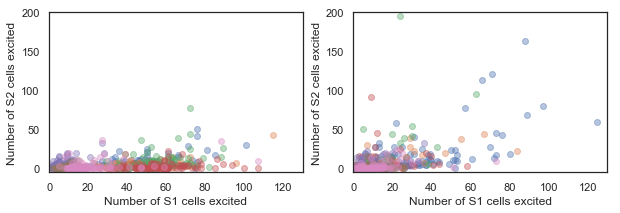

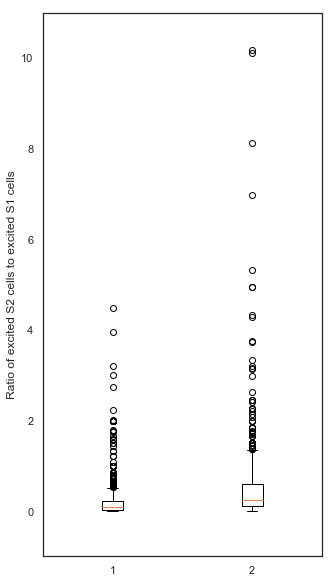

In [228]:
# number of cells excited in s1 and s2

pkl_folder = r'P:\rlees\pkl_files'

plt.figure(figsize=(10,10))

ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
# ax3 = plt.subplot(323)
# ax4 = plt.subplot(324)
# ax5 = plt.subplot(325)
# ax6 = plt.subplot(326)

rand_ratio_s1_s2 = []
sensory_ratio_s1_s2 = []

for root, dirs, files in os.walk(pkl_folder):
    for pkl_file in files:
        pkl_path = os.path.join(pkl_folder, pkl_file)
        print(pkl_path)
        
        with open(pkl_path, 'rb') as f:
            exp_obj = pickle.load(f)
        
        trial_s1_count = []
        trial_s2_count = []
        
        if 'spont' not in pkl_file:
        
            for trial in range(exp_obj.n_trials):

                s1_count = 0
                s2_count = 0

                for cell,_ in enumerate(exp_obj.cell_id[0]):

    #                 if exp_obj.single_sig[0][cell][trial] == True and exp_obj.cell_med[0][cell][1] < 400:
                    if exp_obj.single_sig[0][cell][trial] == True and exp_obj.all_amplitudes[0][cell][trial] > 0 and exp_obj.cell_med[0][cell][1] < 400:
                        s1_count += 1
    #                 if exp_obj.single_sig[0][cell][trial] == True and exp_obj.cell_med[0][cell][1] > 450:
                    if exp_obj.single_sig[0][cell][trial] == True and exp_obj.all_amplitudes[0][cell][trial] > 0 and exp_obj.cell_med[0][cell][1] > 450:
                        s2_count += 1

                trial_s1_count.append(s1_count)
                trial_s2_count.append(s2_count)

            if 'random' in pkl_file:
                ax1.scatter(trial_s1_count, trial_s2_count, label=exp_obj.sheet_name, alpha=0.4)
#                 ax3.hist(trial_s1_count, histtype='step')
#                 ax5.hist(trial_s2_count, histtype='step')
                try:
                    rand_ratio_s1_s2.append([s2_count/(s1_count+0.01) for s1_count,s2_count in zip(trial_s1_count, trial_s2_count)])
                except:
                    print('Error in ratio calculation.')
                    
            if 'sensory' in pkl_file:
                ax2.scatter(trial_s1_count, trial_s2_count, label=exp_obj.sheet_name, alpha=0.4)
#                 ax4.hist(trial_s1_count, histtype='step')
#                 ax6.hist(trial_s2_count, histtype='step')
                try:
                    sensory_ratio_s1_s2.append([s2_count/(s1_count+0.01) for s1_count,s2_count in zip(trial_s1_count, trial_s2_count)])
                except:
                    print('Error in ratio calculation.')
    
    rand_ratio_s1_s2 = [item for sublist in rand_ratio_s1_s2 for item in sublist]
    sensory_ratio_s1_s2 = [item for sublist in sensory_ratio_s1_s2 for item in sublist]

ax1.set_ylim((-5,200))
ax2.set_ylim((-5,200))
ax1.set_xlim((0,130))
ax2.set_xlim((0,130))
# ax3.set_xlim((0,200))
# ax4.set_xlim((0,200))
# ax5.set_xlim((0,200))
# ax6.set_xlim((0,200))
# ax3.set_xlim((0,100))
# ax4.set_xlim((0,100))
# ax5.set_xlim((0,100))
# ax6.set_xlim((0,100))

ax1.set_xlabel('Number of S1 cells excited')
ax2.set_xlabel('Number of S1 cells excited')
ax1.set_ylabel('Number of S2 cells excited')
ax2.set_ylabel('Number of S2 cells excited')

plt.figure(figsize=(5,10));
plt.boxplot([rand_ratio_s1_s2,sensory_ratio_s1_s2]);
plt.ylabel('Ratio of excited S2 cells to excited S1 cells');
plt.ylim(-1,11);
stats.wilcoxon(rand_ratio_s1_s2, sensory_ratio_s1_s2)

P:\rlees\pkl_files\2019-06-11_J048_exp0_random.pkl
P:\rlees\pkl_files\2019-06-11_J048_exp1_sensory.pkl
P:\rlees\pkl_files\2019-06-13_J052_exp0_random.pkl
P:\rlees\pkl_files\2019-06-13_J052_exp1_sensory.pkl
P:\rlees\pkl_files\2019-06-25_RL048_exp0_random.pkl
P:\rlees\pkl_files\2019-06-25_RL048_exp1_sensory.pkl
P:\rlees\pkl_files\2019-07-15_RL052_exp0_random.pkl
P:\rlees\pkl_files\2019-07-15_RL052_exp1_sensory.pkl
P:\rlees\pkl_files\2019-08-14_J058_exp0_random.pkl
P:\rlees\pkl_files\2019-08-14_J058_exp1_sensory.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp0_spont.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp0_spont_sham.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp1_random.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp2_sensory.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp0_spont.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp0_spont_sham.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp1_random.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp2_sensory.pkl


Text(0, 0.5, 'Number of S2 cells excited')

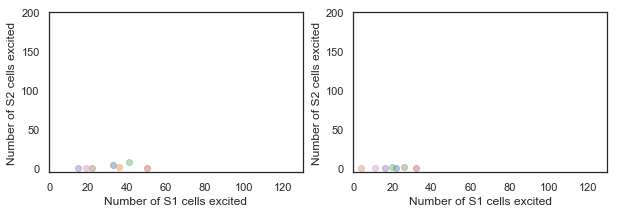

In [274]:
# number of cells excited in s1 and s2 STA

pkl_folder = r'P:\rlees\pkl_files'

plt.figure(figsize=(10,10))

ax1 = plt.subplot(321)
ax2 = plt.subplot(322)

for root, dirs, files in os.walk(pkl_folder):
    for pkl_file in files:
        pkl_path = os.path.join(pkl_folder, pkl_file)
        print(pkl_path)
        
        with open(pkl_path, 'rb') as f:
            exp_obj = pickle.load(f)
       
        if 'spont' not in pkl_file:
            
            sig_units = [i for i,cell in enumerate(exp_obj.cell_id[0]) if cell in exp_obj.sta_sig[0]]
            n_s2_cells = len([i for i,sig in enumerate(exp_obj.sta_sig[0]) if sig in sig_units and exp_obj.cell_med[0][sig][1] > 450])
            n_s1_cells = len([i for i,sig in enumerate(exp_obj.sta_sig[0]) if sig in sig_units and exp_obj.cell_med[0][sig][1] < 400])

            if 'random' in pkl_file:
                ax1.scatter(n_s1_cells, n_s2_cells, label=exp_obj.sheet_name, alpha=0.4)

            if 'sensory' in pkl_file:
                ax2.scatter(n_s1_cells, n_s2_cells, label=exp_obj.sheet_name, alpha=0.4)

ax1.set_ylim((-5,200))
ax2.set_ylim((-5,200))
ax1.set_xlim((0,130))
ax2.set_xlim((0,130))

ax1.set_xlabel('Number of S1 cells excited');
ax2.set_xlabel('Number of S1 cells excited');
ax1.set_ylabel('Number of S2 cells excited');
ax2.set_ylabel('Number of S2 cells excited');

P:\rlees\pkl_files\2019-06-11_J048_exp0_random.pkl
P:\rlees\pkl_files\2019-06-11_J048_exp1_sensory.pkl
P:\rlees\pkl_files\2019-06-13_J052_exp0_random.pkl
P:\rlees\pkl_files\2019-06-13_J052_exp1_sensory.pkl
P:\rlees\pkl_files\2019-06-25_RL048_exp0_random.pkl
P:\rlees\pkl_files\2019-06-25_RL048_exp1_sensory.pkl
P:\rlees\pkl_files\2019-07-15_RL052_exp0_random.pkl
P:\rlees\pkl_files\2019-07-15_RL052_exp1_sensory.pkl
P:\rlees\pkl_files\2019-08-14_J058_exp0_random.pkl
P:\rlees\pkl_files\2019-08-14_J058_exp1_sensory.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp0_spont.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp0_spont_sham.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp1_random.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp2_sensory.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp0_spont.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp0_spont_sham.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp1_random.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp2_sensory.pkl


Text(0, 0.5, 'Proportion of S2 cells excited')

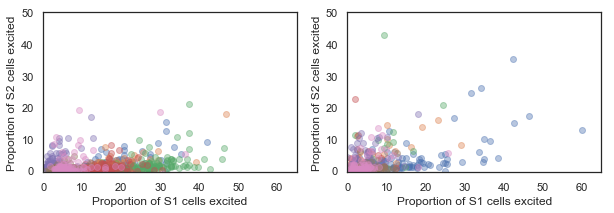

In [229]:
# proportion of cells excited in s1 and s2

pkl_folder = r'P:\rlees\pkl_files'

plt.figure(figsize=(10,10))

ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
# ax3 = plt.subplot(323)
# ax4 = plt.subplot(324)
# ax5 = plt.subplot(325)
# ax6 = plt.subplot(326)

for root, dirs, files in os.walk(pkl_folder):
    for pkl_file in files:
        pkl_path = os.path.join(pkl_folder, pkl_file)
        print(pkl_path)
        
        if 'spont' not in pkl_file:
            
            with open(pkl_path, 'rb') as f:
                exp_obj = pickle.load(f)

            trial_s1_count = []
            trial_s2_count = []

            for trial in range(exp_obj.n_trials):

                s1_count = 0
                s2_count = 0

                for cell,_ in enumerate(exp_obj.cell_id[0]):

    #                 if exp_obj.single_sig[0][cell][trial] == True and exp_obj.cell_med[0][cell][1] < 400:
                    if exp_obj.single_sig[0][cell][trial] == True and exp_obj.all_amplitudes[0][cell][trial] > 0 and exp_obj.cell_med[0][cell][1] < 400:
                        s1_count += 1
    #                 if exp_obj.single_sig[0][cell][trial] == True and exp_obj.cell_med[0][cell][1] > 450:
                    if exp_obj.single_sig[0][cell][trial] == True and exp_obj.all_amplitudes[0][cell][trial] > 0 and exp_obj.cell_med[0][cell][1] > 450:
                        s2_count += 1

                trial_s1_count.append(s1_count)
                trial_s2_count.append(s2_count)
            
            total_s1_cells = len([x for y,x in exp_obj.cell_med[0][:] if x < 400])
            total_s2_cells = len([x for y,x in exp_obj.cell_med[0][:] if x > 450])
            
            percent_s1_count = [(x/total_s1_cells)*100 for x in trial_s1_count]
            percent_s2_count = [(x/total_s2_cells)*100 for x in trial_s2_count]
            
            if 'random' in pkl_file:
                ax1.scatter(percent_s1_count, percent_s2_count, label=exp_obj.sheet_name, alpha=0.4)
#                 ax3.hist(percent_s1_count, histtype='step')
#                 ax5.hist(percent_s2_count, histtype='step')
            if 'sensory' in pkl_file:
                ax2.scatter(percent_s1_count, percent_s2_count, label=exp_obj.sheet_name, alpha=0.4)
#                 ax4.hist(percent_s1_count, histtype='step')
#                 ax6.hist(percent_s2_count, histtype='step')

ax1.set_ylim((-.5,50))
ax2.set_ylim((-.5,50))
ax1.set_xlim((0,65))
ax2.set_xlim((0,65))
# ax3.set_xlim((0,10))
# ax4.set_xlim((0,10))
# ax5.set_xlim((0,10))
# ax6.set_xlim((0,10))
# ax3.set_ylim((0,100))
# ax4.set_ylim((0,100))
# ax5.set_ylim((0,100))
# ax6.set_ylim((0,100))

ax1.set_xlabel('Proportion of S1 cells excited')
ax2.set_xlabel('Proportion of S1 cells excited')
ax1.set_ylabel('Proportion of S2 cells excited')
ax2.set_ylabel('Proportion of S2 cells excited')

P:\rlees\pkl_files\2019-06-11_J048_exp0_random.pkl
P:\rlees\pkl_files\2019-06-11_J048_exp1_sensory.pkl
P:\rlees\pkl_files\2019-06-13_J052_exp0_random.pkl
P:\rlees\pkl_files\2019-06-13_J052_exp1_sensory.pkl
P:\rlees\pkl_files\2019-06-25_RL048_exp0_random.pkl
P:\rlees\pkl_files\2019-06-25_RL048_exp1_sensory.pkl
P:\rlees\pkl_files\2019-07-15_RL052_exp0_random.pkl
P:\rlees\pkl_files\2019-07-15_RL052_exp1_sensory.pkl
P:\rlees\pkl_files\2019-08-14_J058_exp0_random.pkl
P:\rlees\pkl_files\2019-08-14_J058_exp1_sensory.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp0_spont.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp0_spont_sham.pkl
0.0002770990623554016
P:\rlees\pkl_files\2019-08-14_J059_exp1_random.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp2_sensory.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp0_spont.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp0_spont_sham.pkl
4.089742887534547e-16
P:\rlees\pkl_files\2019-08-15_RL055_exp1_random.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp2_sensory.pkl


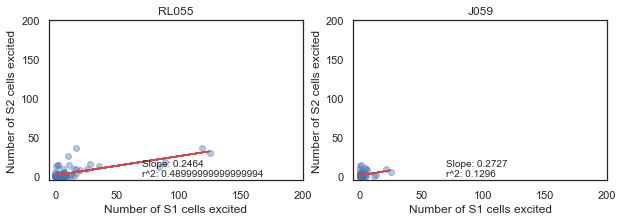

In [287]:
# number/proportion of cells excited in s1 and s2 for spont_sham data

pkl_folder = r'P:\rlees\pkl_files'

plt.figure(figsize=(10,10))

ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
# ax3 = plt.subplot(323)
# ax4 = plt.subplot(324)
# ax5 = plt.subplot(325)
# ax6 = plt.subplot(326)

for root, dirs, files in os.walk(pkl_folder):
    for pkl_file in files:
        pkl_path = os.path.join(pkl_folder, pkl_file)
        print(pkl_path)
        
        if 'spont_sham' in pkl_file:
            
            with open(pkl_path, 'rb') as f:
                exp_obj = pickle.load(f)

            trial_s1_count = []
            trial_s2_count = []
         
            for trial in range(exp_obj.n_trials):

                s1_count = 0
                s2_count = 0

                for cell,_ in enumerate(exp_obj.cell_id[0]):

    #                 if exp_obj.single_sig[0][cell][trial] == True and exp_obj.cell_med[0][cell][1] < 400:
                    if exp_obj.single_sig[0][cell][trial] == True and exp_obj.all_amplitudes[0][cell][trial] > 0 and exp_obj.cell_med[0][cell][1] < 400:
                        s1_count += 1
    #                 if exp_obj.single_sig[0][cell][trial] == True and exp_obj.cell_med[0][cell][1] > 450:
                    if exp_obj.single_sig[0][cell][trial] == True and exp_obj.all_amplitudes[0][cell][trial] > 0 and exp_obj.cell_med[0][cell][1] > 450:
                        s2_count += 1

                trial_s1_count.append(s1_count)
                trial_s2_count.append(s2_count)
            
            total_s1_cells = len([x for y,x in exp_obj.cell_med[0][:] if x < 400])
            total_s2_cells = len([x for y,x in exp_obj.cell_med[0][:] if x > 450])
            
            percent_s1_count = [(x/total_s1_cells)*100 for x in trial_s1_count]
            percent_s2_count = [(x/total_s2_cells)*100 for x in trial_s2_count]
            
            if 'RL055' in pkl_file:
                ax1.scatter(trial_s1_count, trial_s2_count, label=exp_obj.sheet_name, alpha=0.4)
#                 ax3.hist(percent_s1_count, histtype='step')
#                 ax5.hist(percent_s2_count, histtype='step')
                
                # calc the trendline
                z = np.polyfit(trial_s1_count, trial_s2_count, 1)
                p = np.poly1d(z)
                ax1.plot(trial_s1_count,p(trial_s1_count),'r')
                slope, intercept, r_value, p_value, std_err = stats.linregress(trial_s1_count,trial_s2_count)
                slope = np.around(slope, decimals=4)
                r_value = np.around(r_value, decimals=2)
                ax1.text(70, 0.1, 'Slope: ' + str(slope) + '\nr^2: ' + str(np.square(r_value))) 
                
            if 'J059' in pkl_file:
                ax2.scatter(trial_s1_count, trial_s2_count, label=exp_obj.sheet_name, alpha=0.4)
#                 ax4.hist(percent_s1_count, histtype='step')
#                 ax6.hist(percent_s2_count, histtype='step')
                
                # calc the trendline
                z = np.polyfit(trial_s1_count, trial_s2_count, 1)
                p = np.poly1d(z)
                ax2.plot(trial_s1_count,p(trial_s1_count),'r')
                slope, intercept, r_value, p_value, std_err = stats.linregress(trial_s1_count,trial_s2_count)
                slope = np.around(slope, decimals=4)
                r_value = np.around(r_value, decimals=2)
                ax2.text(70, 0.1, 'Slope: ' + str(slope) + '\nr^2: ' + str(np.square(r_value))) 

ax1.set_ylim((-5,200));
ax2.set_ylim((-5,200));
ax1.set_xlim((-5,200));
ax2.set_xlim((-5,200));
# ax3.set_xlim((0,10))
# ax4.set_xlim((0,10))
# ax5.set_xlim((0,10))
# ax6.set_xlim((0,10))
# ax3.set_ylim((0,100))
# ax4.set_ylim((0,100))
# ax5.set_ylim((0,100))
# ax6.set_ylim((0,100))

ax1.set_xlabel('Number of S1 cells excited');
ax2.set_xlabel('Number of S1 cells excited');
ax1.set_ylabel('Number of S2 cells excited');
ax2.set_ylabel('Number of S2 cells excited');
ax1.set_title('RL055');
ax2.set_title('J059');

In [1379]:
# Recreate STA postage of cells

# Maybe make the STA movie from the frames that are relevant, adding it to the first stack. 
# I.e. Load stack 1, add stack 2... add stack n and then divide by the number of trials to get the STA
# Save the STA for later cropping using ROIs

# Alternatively for each trial (as an additional argument) look at the postage stamp for that trial
# to see if it look like a cell increasing in intensity

pkl_folder = r'P:\rlees\pkl_files'
plane = 0

# Need to find bounding box of cell from x and y pix extremes and make a border around that to crop STA
# ORIGIN = top-left, y = 0, x = 0

for root, dirs, files in os.walk(pkl_folder):
    for file in files:
        pkl_path = os.path.join(pkl_folder, file)
        
        with open(pkl_path, 'rb') as f:
            exp_obj = pickle.load(f)
        
        print(exp_obj.tiff_path)
        
        try:
            output_dir = os.path.join(exp_obj.tiff_path, 'targ_cells_dff')
            os.mkdir(output_dir)
        except:
            print('Could not make directory.')
            
        for trial in range(exp_obj.n_trials):

            for cell,_ in enumerate(exp_obj.cell_id[0]):

                if exp_obj.targeted_cells[cell]==1 and exp_obj.single_sig[0][cell][trial] == True and exp_obj.all_amplitudes[0][cell][trial] > 0:
#                 if exp_obj.single_sig[0][cell][trial] == True and exp_obj.all_amplitudes[0][cell][trial] > 20:

                    min_x = np.min(exp_obj.cell_x[plane][cell])
                    max_x = np.max(exp_obj.cell_x[plane][cell])
                    width_cell = max_x - min_x

                    min_y = np.min(exp_obj.cell_y[plane][cell])
                    max_y = np.max(exp_obj.cell_y[plane][cell])
                    height_cell = max_y - min_y

                    bd_x_start = (min_x - 10)
                    bd_width = width_cell + 20
                    bd_x_stop = bd_x_start + bd_width
                    
                    if bd_x_start < 0:
                        bd_x_start = 0
                        
                    if bd_x_stop > exp_obj.frame_x:
                        bd_x_stop = exp_obj.frame_x
                        
                    bd_y_start = (min_y - 10)
                    bd_height = height_cell + 20
                    bd_y_stop = bd_y_start + bd_height
                    
                    if bd_y_start < 0:
                        bd_y_start = 0
                        
                    if bd_y_stop > exp_obj.frame_y:
                        bd_y_stop = exp_obj.frame_y

                    frame_start = exp_obj.stim_start_frames[plane][trial]
                    trial_start = frame_start - exp_obj.pre_frames
                    trial_end = frame_start + exp_obj.pre_frames + int(exp_obj.stim_dur/exp_obj.fps)

                    for file in os.listdir(exp_obj.tiff_path):
                        if '.tif' in file:
                            tiff_file = os.path.join(exp_obj.tiff_path, file)
                            trial_stack = tf.imread(tiff_file, key=range(trial_start,trial_end))

                            trial_baseline = trial_stack[: exp_obj.pre_frames, :, :]
                            baseline_avg = np.mean(trial_baseline, 0)

                            df_stack = trial_stack - baseline_avg
                            dff_stack = df_stack/baseline_avg * 100
                            dff_stack = dff_stack.astype('uint32')

                            cell_stack = dff_stack[-10:,bd_y_start:bd_y_stop, bd_x_start:bd_x_stop]
                            break

                    output_path = os.path.join(exp_obj.tiff_path, 'targ_cells_dff', file + '_plane' + str(plane) + '_cell' + str(cell) + '_trial' + str(trial) + '.tif')
                    tf.imwrite(output_path, cell_stack)

P:\rlees\Data\2019-06-11\J048\2019-06-11_J048_t-005
Could not make directory.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide


P:\rlees\Data\2019-06-11\J048\2019-06-11_J048_t-006
P:\sarmstrong\Data\2019-06-25\RL048\2019-06-24_RL048_t-005
P:\sarmstrong\Data\2019-06-25\RL048\2019-06-24_RL048_t-006\MPTIFF
P:\rlees\Data\2019-07-15\2019-07-15_RL052\2019-07-15_RL052_t-007


KeyboardInterrupt: 

In [129]:
# Make and save STA of trials where lots of S2 cells go off to see what is happening as sanity check

plane = 0
pkl_folder = r'P:\rlees\pkl_files'

for root, dirs, files in os.walk(pkl_folder):
    for file in files:
        pkl_path = os.path.join(pkl_folder, file)
        print(pkl_path)
        
        if any(s in pkl_path for s in ['random', 'sensory', 'sham']):
            with open(pkl_path, 'rb') as f:
                exp_obj = pickle.load(f)

            try:
                output_dir = os.path.join(exp_obj.tiff_path, 'sta_many_s2_cells')
                os.mkdir(output_dir)
            except:
                print('Could not make directory.')

            for trial in range(exp_obj.n_trials):

                s1_count = 0
                s2_count = 0

                for cell,_ in enumerate(exp_obj.cell_id[0]):

                    if exp_obj.single_sig[0][cell][trial] == True and exp_obj.all_amplitudes[0][cell][trial] > 0 and exp_obj.cell_med[0][cell][1] < 400:
                        s1_count += 1

                    if exp_obj.single_sig[0][cell][trial] == True and exp_obj.all_amplitudes[0][cell][trial] > 0 and exp_obj.cell_med[0][cell][1] > 450:
                        s2_count += 1

                if s2_count > 20:

                    frame_start = exp_obj.stim_start_frames[plane][trial]
                    trial_start = frame_start - exp_obj.pre_frames
                    trial_end = frame_start + exp_obj.pre_frames + int(exp_obj.stim_dur/exp_obj.fps)

                    for file in os.listdir(exp_obj.tiff_path):
                        if '.tif' in file:
                            tiff_file = os.path.join(exp_obj.tiff_path, file)
                            trial_stack = tf.imread(tiff_file, key=range(trial_start,trial_end))

                            trial_baseline = trial_stack[: exp_obj.pre_frames, :, :]
                            baseline_avg = np.mean(trial_baseline, 0)

                            df_stack = trial_stack - baseline_avg
                            dff_stack = df_stack/baseline_avg * 100
                            dff_stack = dff_stack.astype('uint32')
#                             dff_stack = dff_stack[-10:,:,:]

                            break

                    output_path = os.path.join(output_dir, file + '_plane' + str(plane) + '_trial' + str(trial) + '_' + str(s2_count) + 'cells.tif')
                    tf.imwrite(output_path, dff_stack)
                    print(output_path)

P:\rlees\pkl_files\2019-06-11_J048_exp0_random.pkl
Could not make directory.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


P:\rlees\Data\2019-06-11\J048\2019-06-11_J048_t-005\sta_many_s2_cells\2019-06-11_J048_t-005_Cycle00001_Ch3.tif_plane0_trial7_25cells.tif
P:\rlees\Data\2019-06-11\J048\2019-06-11_J048_t-005\sta_many_s2_cells\2019-06-11_J048_t-005_Cycle00001_Ch3.tif_plane0_trial17_41cells.tif
P:\rlees\Data\2019-06-11\J048\2019-06-11_J048_t-005\sta_many_s2_cells\2019-06-11_J048_t-005_Cycle00001_Ch3.tif_plane0_trial37_50cells.tif
P:\rlees\Data\2019-06-11\J048\2019-06-11_J048_t-005\sta_many_s2_cells\2019-06-11_J048_t-005_Cycle00001_Ch3.tif_plane0_trial53_22cells.tif
P:\rlees\Data\2019-06-11\J048\2019-06-11_J048_t-005\sta_many_s2_cells\2019-06-11_J048_t-005_Cycle00001_Ch3.tif_plane0_trial54_21cells.tif
P:\rlees\Data\2019-06-11\J048\2019-06-11_J048_t-005\sta_many_s2_cells\2019-06-11_J048_t-005_Cycle00001_Ch3.tif_plane0_trial55_29cells.tif
P:\rlees\Data\2019-06-11\J048\2019-06-11_J048_t-005\sta_many_s2_cells\2019-06-11_J048_t-005_Cycle00001_Ch3.tif_plane0_trial72_30cells.tif
P:\rlees\Data\2019-06-11\J048\2019-

In [144]:
def points_in_circle_np(radius, x0=0, y0=0, ):
    x_ = np.arange(x0 - radius - 1, x0 + radius + 1, dtype=int)
    y_ = np.arange(y0 - radius - 1, y0 + radius + 1, dtype=int)
    x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
    for x, y in zip(x_[x], y_[y]):
        yield x, y

In [125]:
# Make STA of target location (see photostim resolution?)

pkl_folder = r'P:\rlees\pkl_files'
plane = 0

for root, dirs, files in os.walk(pkl_folder):
    for file in files:
        pkl_path = os.path.join(pkl_folder, file)
        print(pkl_path)
        
        with open(pkl_path, 'rb') as f:
            exp_obj = pickle.load(f)
        
        try:
            output_dir = os.path.join(exp_obj.tiff_path, 'targets_dff')
            os.mkdir(output_dir)
        except:
            print('Could not make directory.')
            
        for i,target in enumerate(exp_obj.target_coords):
            
            target_stack = np.empty((0,10,40,40), dtype=np.uint32)
            
            for trial in range(exp_obj.n_trials):
                
                bd_x_start = (target[0] - 10)
                bd_width = 40
                bd_x_stop = bd_x_start + bd_width

                bd_y_start = (target[1] - 10)
                bd_height = 40
                bd_y_stop = bd_y_start + bd_height

                frame_start = exp_obj.stim_start_frames[plane][trial]
                trial_start = frame_start - exp_obj.pre_frames
                trial_end = frame_start + exp_obj.pre_frames + int(exp_obj.stim_dur/exp_obj.fps)

                for file in os.listdir(exp_obj.tiff_path):
                    if '.tif' in file:
                        tiff_file = os.path.join(exp_obj.tiff_path, file)
                        trial_stack = tf.imread(tiff_file, key=range(trial_start,trial_end))

                        trial_baseline = trial_stack[: exp_obj.pre_frames, :, :]
                        baseline_avg = np.mean(trial_baseline, 0)

                        df_stack = trial_stack - baseline_avg
                        dff_stack = df_stack/baseline_avg * 100
                        dff_stack = dff_stack.astype('uint32')

                        crop_stack = dff_stack[-10:,bd_y_start:bd_y_stop, bd_x_start:bd_x_stop]
                        crop_stack = np.expand_dims(crop_stack, axis=0)
                        target_stack = np.append(target_stack, crop_stack, axis=0)
                        break

            output_path = os.path.join(exp_obj.tiff_path, 'targets_dff', file + '_plane' + str(plane) + '_target' + str(i) + '.tif')
            tf.imwrite(output_path, target_stack)

P:\rlees\pkl_files\2019-06-11_J048_exp0_random.pkl
Could not make directory.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


KeyboardInterrupt: 

In [261]:
# Find the proportion of targeted cells that responded (significantly) across trials,
# does it hover at same value or fluctuate?

all_prop_targ_resp = []
all_n_targ_resp = []
all_targ_amps = []

all_prop_s2_exc = []
all_n_s2_exc = []

all_prop_s2_inh = []
all_n_s2_inh = []

all_s2_amps = []

for root, dirs, files in os.walk(pkl_folder):
    for file in files:
        pkl_path = os.path.join(pkl_folder, file)
        print(pkl_path)
                
#         if any(s in pkl_path for s in ['random', 'sensory']):
        if 'spont_sham' in pkl_path:
           
            with open(pkl_path, 'rb') as f:
                exp_obj = pickle.load(f)
        
            n_targeted_cells = len([x for x in exp_obj.targeted_cells if x == 1])

            n_s2_cells = len([x for y,x in exp_obj.cell_med[0][:] if x > 450])

            for trial in range(exp_obj.n_trials):
                num_targets_exc = len([i for i,target in enumerate(exp_obj.targeted_cells) if target == 1 and exp_obj.all_amplitudes[0][i][trial] > 0 and exp_obj.single_sig[0][i][trial]])
                proportion_targets = num_targets_exc/n_targeted_cells
                
                trial_targ_amps = [exp_obj.all_amplitudes[0][i][trial] for i,target in enumerate(exp_obj.targeted_cells) if target == 1 and exp_obj.single_sig[0][i][trial]]
                all_targ_amps.append(trial_targ_amps)
                
                all_prop_targ_resp.append(proportion_targets)
                all_n_targ_resp.append(num_targets_exc)

                num_s2_exc = len([i for i,_ in enumerate(exp_obj.cell_id[0]) if exp_obj.all_amplitudes[0][i][trial] > 0 and exp_obj.single_sig[0][i][trial] and exp_obj.cell_med[0][i][1] > 450])
                proportion_s2_exc = num_s2_exc/n_s2_cells
                num_s2_inh = len([i for i,_ in enumerate(exp_obj.cell_id[0]) if exp_obj.all_amplitudes[0][i][trial] < 0 and exp_obj.single_sig[0][i][trial] and exp_obj.cell_med[0][i][1] > 450])
                proportion_s2_inh = num_s2_inh/n_s2_cells
                
                trial_s2_amps = [exp_obj.all_amplitudes[0][i][trial] for i in range(exp_obj.n_units[0]) if exp_obj.single_sig[0][i][trial] and exp_obj.cell_med[0][i][1] > 450]
                all_s2_amps.append(trial_s2_amps)
                
                all_prop_s2_exc.append(proportion_s2_exc)
                all_prop_s2_inh.append(proportion_s2_inh)
                all_n_s2_exc.append(num_s2_exc)
                all_n_s2_inh.append(num_s2_inh)

P:\rlees\pkl_files\2019-06-11_J048_exp0_random.pkl
P:\rlees\pkl_files\2019-06-11_J048_exp1_sensory.pkl
P:\rlees\pkl_files\2019-06-13_J052_exp0_random.pkl
P:\rlees\pkl_files\2019-06-13_J052_exp1_sensory.pkl
P:\rlees\pkl_files\2019-06-25_RL048_exp0_random.pkl
P:\rlees\pkl_files\2019-06-25_RL048_exp1_sensory.pkl
P:\rlees\pkl_files\2019-07-15_RL052_exp0_random.pkl
P:\rlees\pkl_files\2019-07-15_RL052_exp1_sensory.pkl
P:\rlees\pkl_files\2019-08-14_J058_exp0_random.pkl
P:\rlees\pkl_files\2019-08-14_J058_exp1_sensory.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp0_spont.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp0_spont_sham.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp1_random.pkl
P:\rlees\pkl_files\2019-08-14_J059_exp2_sensory.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp0_spont.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp0_spont_sham.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp1_random.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp2_sensory.pkl


TypeError: expected non-empty vector for x

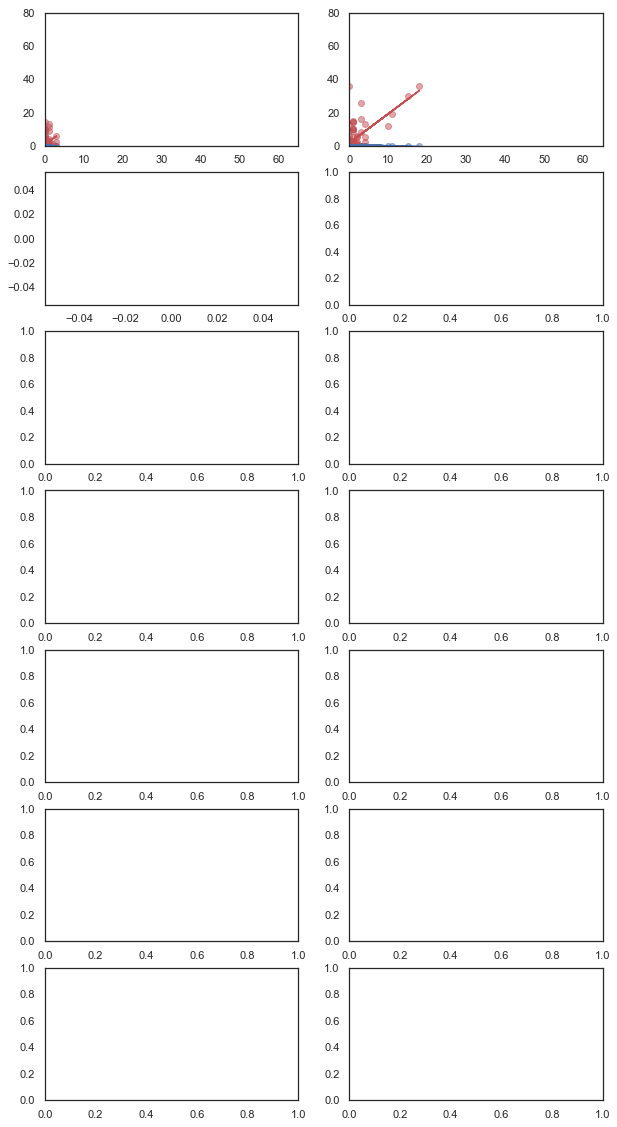

In [262]:
#plot number of exc/inh in cells over trials 

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(10,20))

i=0

for row in ax:
    for col in row:
        y = all_n_s2_inh[i:i+100]
        x = all_n_targ_resp[i:i+100]
        col.scatter(x, y, c='b', alpha=0.5)
        
        # calc the trendline
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        col.plot(x,p(x),'b')
        
        y = all_n_s2_exc[i:i+100]
        x = all_n_targ_resp[i:i+100]
        col.scatter(x, y, c='r', alpha=0.5)
        
        # calc the trendline
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        col.plot(x,p(x),'r')
        
        col.set_xlim((0,65))
        col.set_ylim((0,80))
        i+=100

TypeError: expected non-empty vector for x

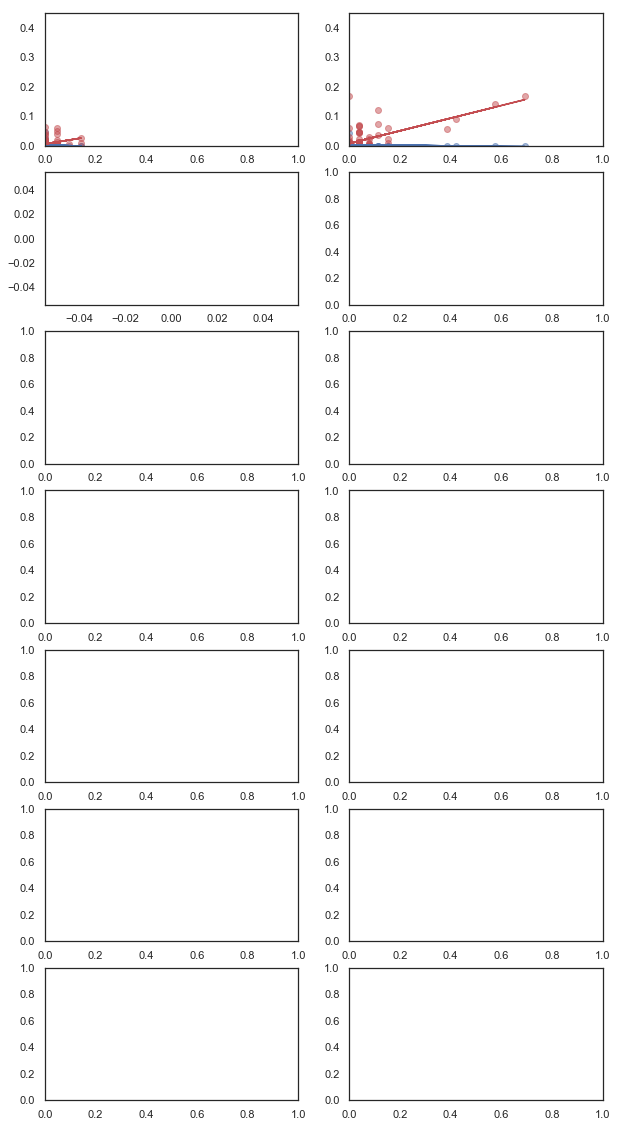

In [263]:
#plot proportion of exc/inh in cells over trials 

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(10,20))

i=0

for row in ax:
    for col in row:
        x = all_prop_targ_resp[i:i+100]
        y = all_prop_s2_inh[i:i+100]
        col.scatter(x, y, c='b', alpha=0.5)
        
        # calc the trendline
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        col.plot(x,p(x),'b')
        
        x = all_prop_targ_resp[i:i+100]
        y = all_prop_s2_exc[i:i+100]
        col.scatter(x, y, c='r', alpha=0.5)
        
        # calc the trendline
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        col.plot(x,p(x),'r')
        
        col.set_xlim((0,1))
        col.set_ylim((0,.45))
        i+=100

TypeError: expected non-empty vector for x

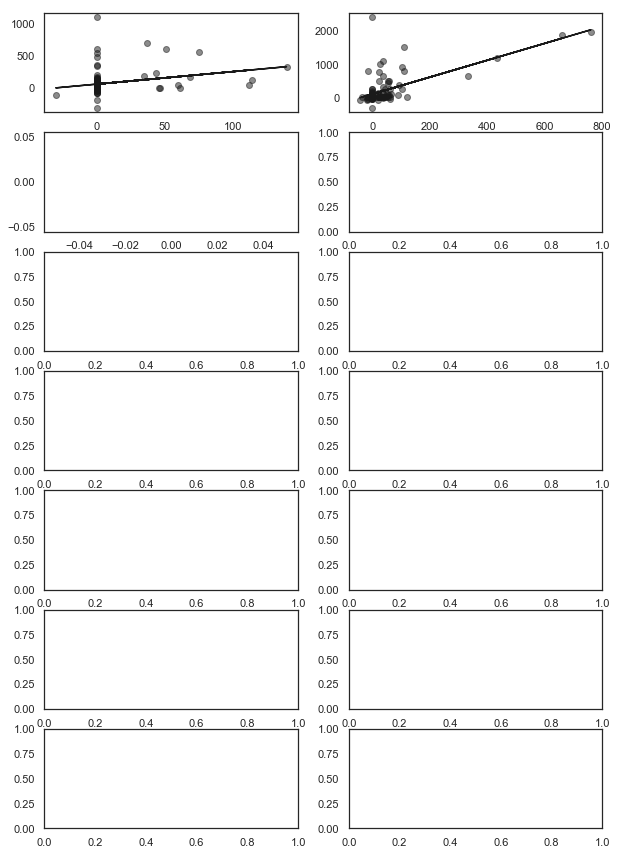

In [264]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(10,15))

i=0

for row in ax:
    for col in row:
        x = all_targ_amps[i:i+100]
        y = all_s2_amps[i:i+100]

        x_mean = [np.sum(sublist) for sublist in x]
        y_mean = [np.sum(sublist) for sublist in y]
        
        col.scatter(x_mean, y_mean, c='k', alpha=0.5)

        # calc the trendline
        z = np.polyfit(x_mean, y_mean, 1)
        p = np.poly1d(z)
        col.plot(x_mean,p(x_mean),'k')
        
        i+=100

ValueError: zero-size array to reduction operation maximum which has no identity

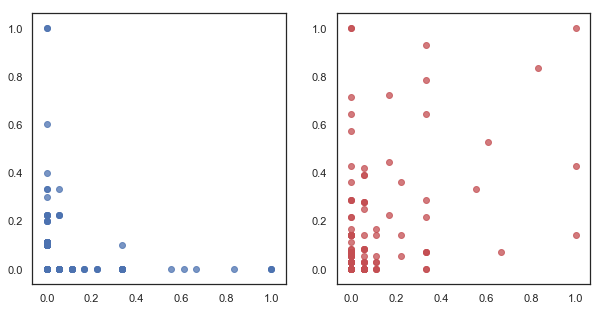

In [265]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

i=0

exc_norm_x = []
exc_norm_y = []
inh_norm_x = []
inh_norm_y = []

# for row in ax:
#     for col in row:
for session in range(14):
    x = all_n_targ_resp[i:i+100]
    y = all_n_s2_inh[i:i+100]
    
    max_x = np.max(x)
    min_x = np.min(x)
    max_y = np.max(y)
    min_y = np.min(y)

    x = (x-min_x)/max_x
    y = (y-min_y)/max_y

    ax[0].scatter(x, y, c='b', alpha=0.75)
    
    exc_norm_x.extend(x)
    exc_norm_y.extend(y)
    
    x = all_n_targ_resp[i:i+100]
    y = all_n_s2_exc[i:i+100]
    
    max_x = np.max(x)
    min_x = np.min(x)
    max_y = np.max(y)
    min_y = np.min(y)

    x = (x-min_x)/max_x
    y = (y-min_y)/max_y
    
    ax[1].scatter(x, y, c='r', alpha=0.75)

    inh_norm_x.extend(x)
    inh_norm_y.extend(y)

    i+=100

P:\rlees\pkl_files\2019-08-14_J059_exp0_spont_sham.pkl
P:\rlees\pkl_files\2019-08-15_RL055_exp0_spont_sham.pkl


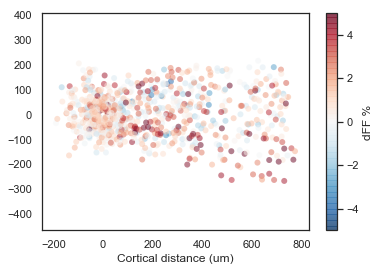

In [255]:
# plot sta excitation and inhibition in space 

pkl_folder = r'P:\rlees\pkl_files'

plt.figure()

all_amps = []
all_dists = []
all_x = []
all_y = []

for root, dirs, files in os.walk(pkl_folder):
    for file in files:
        pkl_path = os.path.join(pkl_folder, file)

        if 'spont_sham' in pkl_path:
#         if any(s in pkl_path for s in ['random', 'sensory']):

            print(pkl_path)
            
            with open(pkl_path, 'rb') as f:
                exp_obj = pickle.load(f)

            followers = []

            for cell in range(exp_obj.n_units[0]):
                cell_coord = exp_obj.cell_med[0][cell]

                if exp_obj.targeted_cells[cell]==0:
                    followers.append(([cell_coord[1],cell_coord[0]], exp_obj.sta_amplitudes[0][cell]))

#             plt.figure();
            
            tree = spatial.KDTree(exp_obj.target_coords)
            
            norm_x = []
            norm_y = []
            amps = []
            dists = []

            for coord, amp in followers:
                dist, index = tree.query(coord)
                x,y = np.subtract(coord, exp_obj.target_coords[index])
                norm_x.append(x)
                norm_y.append(y)
                amps.append(amp)         
                dists.append(dist)
            
            x_um = [x*exp_obj.pix_sz_x for x in norm_x]
            y_um = [y*exp_obj.pix_sz_y for y in norm_y]
            sc = plt.scatter(x_um, y_um, c=amps, cmap='RdBu_r', vmin=-5, vmax=5, alpha=0.5, linewidth=0)
            plt.axis('equal')
#             plt.xlim((-150,150))
#             plt.ylim((-150,150))
            plt.xlabel('Cortical distance (um)')
        
            all_amps.extend(amps)
            all_dists.extend(np.absolute(dists))
            all_x.extend(x_um)
            all_y.extend(y_um)
            
cb = plt.colorbar(sc)
cb.set_label('dFF %')

In [256]:
# Want to bin all coordinates in to 10x10 um chunks
# Make bins relevant to the max coords? Max x and y
# Use np.digitize to get the coords 

def binned_amplitudes_2d(all_x, all_y, all_amps):
    all_amps_real = np.nan_to_num(all_amps)
    denominator, xedges, yedges = np.histogram2d(all_x, all_y, bins=50)
    nominator, _, _ = np.histogram2d(all_x, all_y, bins=50, weights=all_amps_real)
    h = nominator/denominator
    Y, X = np.meshgrid(xedges, yedges)
    
    plt.figure()
    plt.pcolormesh(X, Y, h, cmap='RdBu_r', vmin=-5, vmax=5)
    plt.xlabel('Cortical distance (um)')
    
    cb = plt.colorbar()
    cb.set_label('dFF %')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


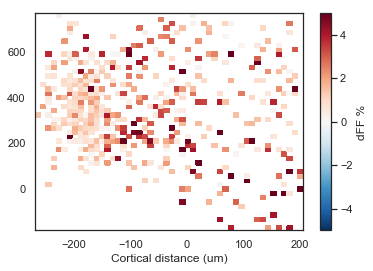

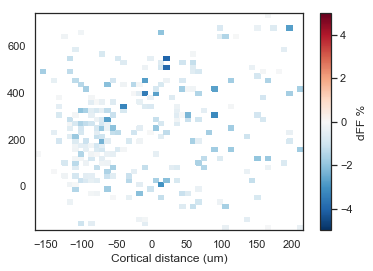

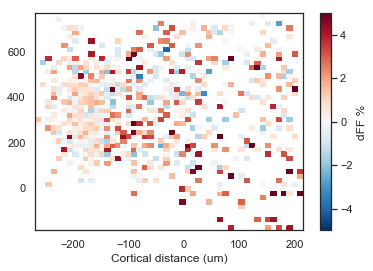

In [257]:
indices = [i for i,amp in enumerate(all_amps) if amp > 0]
x = [x for i,x in enumerate(all_x) if i in indices]
y = [y for i,y in enumerate(all_y) if i in indices]
pos_amps = [amp for i,amp in enumerate(all_amps) if i in indices]

binned_amplitudes_2d(x, y, pos_amps)

indices = [i for i,amp in enumerate(all_amps) if amp < 0]
x = [x for i,x in enumerate(all_x) if i in indices]
y = [y for i,y in enumerate(all_y) if i in indices]
neg_amps = [amp for i,amp in enumerate(all_amps) if i in indices]

binned_amplitudes_2d(x, y, neg_amps)

binned_amplitudes_2d(all_x, all_y, all_amps)

In [258]:
def binned_amplitudes_1d(all_dists,all_amps,bins):
    indices = np.digitize(all_dists, bins)

    binned_amps = []

    for i,_ in enumerate(bins):
        binned_dists = np.where(indices == i)[0]

        if np.shape(binned_dists)[0] > 0:
            amps = [amp for i,amp in enumerate(all_amps) if i in binned_dists]
            mean_amp = np.mean(amps)
            binned_amps.append(mean_amp)
        else:
            binned_amps.append(0)
    
    return binned_amps

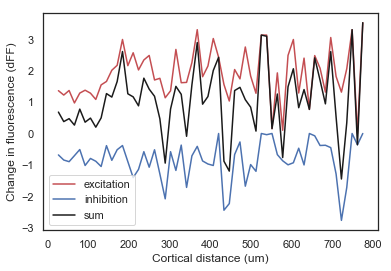

In [259]:
x = range(0,700,10)
x_um = [x*1.313 for x in x]

indices = [i for i,amp in enumerate(all_amps) if amp > 0]
dists = [dist for i,dist in enumerate(all_dists) if i in indices]
pos_amps = [amp for i,amp in enumerate(all_amps) if i in indices]

pos_binned_amps = binned_amplitudes_1d(dists, pos_amps, x)

plt.figure()
plt.plot(x_um[2:-10], pos_binned_amps[2:-10], c='r', label = 'excitation')

indices = [i for i,amp in enumerate(all_amps) if amp < 0]
dists = [dist for i,dist in enumerate(all_dists) if i in indices]
neg_amps = [amp for i,amp in enumerate(all_amps) if i in indices]

neg_binned_amps = binned_amplitudes_1d(dists, neg_amps, x)

plt.plot(x_um[2:-10], neg_binned_amps[2:-10], c='b', label = 'inhibition')

sum_amps = np.add(neg_binned_amps, pos_binned_amps)
plt.plot(x_um[2:-10], sum_amps[2:-10], c='k', label = 'sum')
plt.xlabel('Cortical distance (um)')
plt.ylabel('Change in fluorescence (dFF)')
plt.legend();

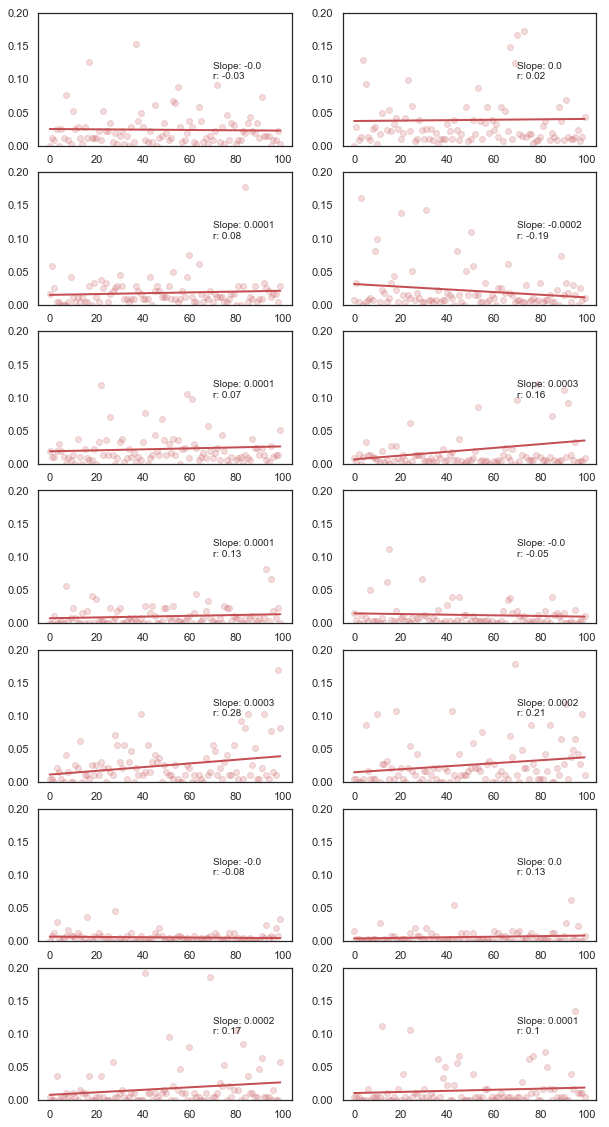

In [260]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(10,20))

i=0

for row in ax:
    for col in row:
        x = range(100)
        y = all_prop_s2_exc[i*100:i*100+100]
        col.scatter(x, y, c='r', alpha=.2)
        # calc the trendline
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        col.plot(x,p(x),"r", lw=2)
        col.set_ylim((0,0.2))
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        slope = np.around(slope, decimals=4)
        r_value = np.around(r_value, decimals=2)
        col.text(70, 0.1, 'Slope: ' + str(slope) + '\nr: ' + str(r_value)) 
        i+=1

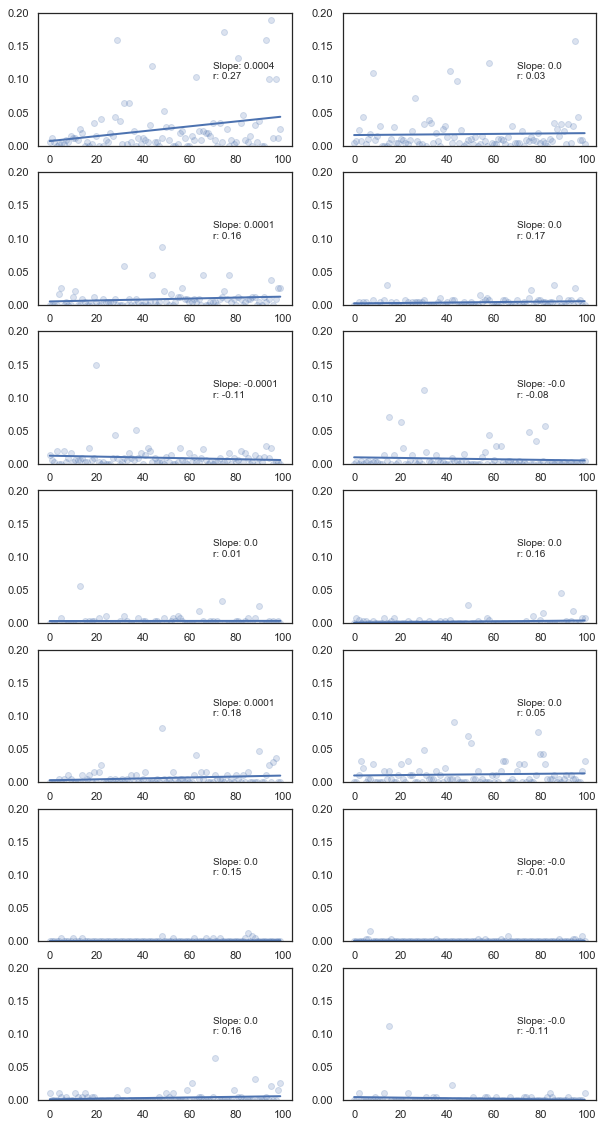

In [122]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(10,20))

i=0

for row in ax:
    for col in row:
        x = range(100)
        y = all_prop_s2_inh[i*100:i*100+100]
        col.scatter(x, y, c='b', alpha=.2)
        # calc the trendline
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        col.plot(x,p(x),"b", lw=2)
        col.set_ylim((0,0.2))
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        slope = np.around(slope, decimals=4)
        r_value = np.around(r_value, decimals=2)
        col.text(70, 0.1, 'Slope: ' + str(slope) + '\nr: ' + str(r_value)) 
        i+=1

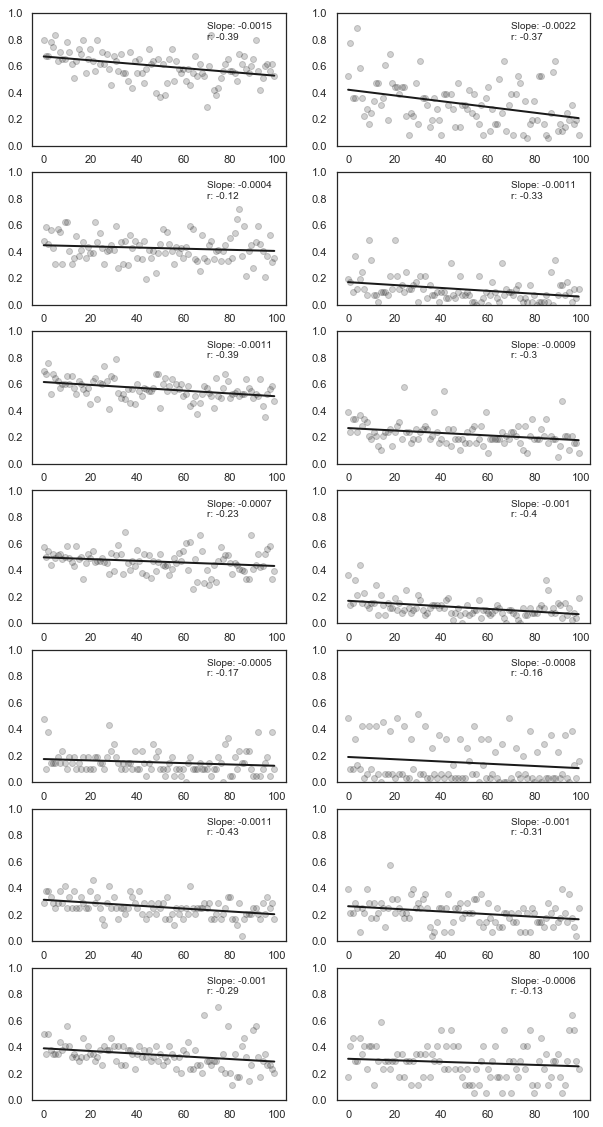

In [233]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(10,20))

i=0

for row in ax:
    for col in row:
        x = range(100)
        y = all_prop_targ_resp[i*100:i*100+100]
        col.scatter(x, y, c='k', alpha=.2)
        # calc the trendline
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        col.plot(x,p(x),"k", lw=2)
        col.set_ylim((0,1))
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        slope = np.around(slope, decimals=4)
        r_value = np.around(r_value, decimals=2)
        col.text(70, 0.8, 'Slope: ' + str(slope) + '\nr: ' + str(r_value)) 
        i+=1

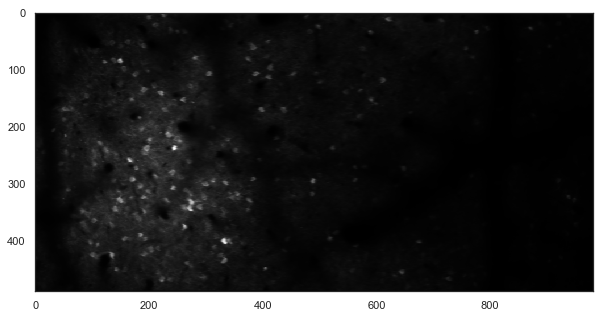

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(exp_obj.mean_img[0], 'gray')